## Imports

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import os
from PIL import Image
from sklearn.manifold import Isomap, TSNE
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

## Read files

In [151]:
# Load the CSV file containing the attributes
csv_path = 'data/train.csv'
df = pd.read_csv(csv_path)

## Buckets

In [152]:
# Define the categories and attributes
categories = ['Men Tshirts', 'Sarees', 'Kurtis', 'Women Tshirts', 'Women Tops & Tunics']
attributes = {
    'Men Tshirts': ['attr_1', 'attr_2'],
    'Sarees': ['attr_1', 'attr_2'],
    'Kurtis': ['attr_1', 'attr_2'],
    'Women Tshirts': ['attr_1', 'attr_2'],
    'Women Tops & Tunics': ['attr_1', 'attr_2']
}

# Create buckets
buckets = []
for category in categories:
    for attribute in attributes[category]:
        buckets.append((category, attribute))

# Function to separate data for each bucket
def separate_data(df, category, attribute):
    bucket_data = df[(df['Category'] == category) & (df[attribute].notnull())]
    return bucket_data

# Separate data for each bucket
bucketed_data = {}
for category, attribute in buckets:
    bucket_data = separate_data(df, category, attribute)
    bucketed_data[(category, attribute)] = bucket_data

# Convert each bucket to a DataFrame and print the head
for bucket, data in bucketed_data.items():
    print(f"Bucket: {bucket}")
    print(len(data))  # Display the shape of each bucket DataFrame

Bucket: ('Men Tshirts', 'attr_1')
6010
Bucket: ('Men Tshirts', 'attr_2')
6144
Bucket: ('Sarees', 'attr_1')
7885
Bucket: ('Sarees', 'attr_2')
17679
Bucket: ('Kurtis', 'attr_1')
6629
Bucket: ('Kurtis', 'attr_2')
3231
Bucket: ('Women Tshirts', 'attr_1')
17285
Bucket: ('Women Tshirts', 'attr_2')
14801
Bucket: ('Women Tops & Tunics', 'attr_1')
14058
Bucket: ('Women Tops & Tunics', 'attr_2')
13337


## Sampling

In [153]:
# Sample 100 samples from each bucket
sampled_data = {}
for bucket, data in bucketed_data.items():
    if len(data) >= 100:
        sampled_data[bucket] = data.sample(n=100, random_state=42)
    else:
        print(f"Not enough samples for bucket {bucket}. Found {len(data)} samples.")

## Encoding

In [154]:
# Perform encoding on the sampled dataset
encoded_data = {}
for bucket, data in sampled_data.items():
    encoded_data[bucket] = pd.get_dummies(data, columns=data.columns.difference(['id', 'Category']))

## Helper

In [157]:
def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                proj[i]
            )
            ax.add_artist(imagebox)

# Function to apply Isomap and t-SNE and visualize the results side by side with images
def visualize_manifold_learning(data, title, image_dir='D:/heisen/IITM studies/4th year/DA5401/Aniket/assignment9/data/train'):
    methods = ['Isomap', 't-SNE']
    models = {
        'Isomap': Isomap(n_neighbors=30, n_components=2),
        't-SNE': TSNE(n_components=2, perplexity=30, n_iter=300)
    }
    
    X = data.drop(columns=['id', 'Category'])
    
    # Load images
    images = []
    for i in range(len(X)):
        image_path = os.path.join(image_dir, f"{int(data.iloc[i]['id']):06d}.jpg")
        image_path = os.path.normpath(image_path)  # Normalize the path
        if os.path.exists(image_path):
            img = Image.open(image_path)
            img.thumbnail((30, 30), Image.LANCZOS)  # Use Image.LANCZOS instead of Image.ANTIALIAS
            images.append(np.array(img))
        else:
            images.append(np.zeros((30, 30, 3)))  # Placeholder for missing images
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    for ax, method in zip(axes, methods):
        model = models[method]
        plot_components(X, model, images=images, ax=ax)
        ax.set_title(f"{title} - {method}")
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
    
    plt.show()

## Iso-Map and T-SNE

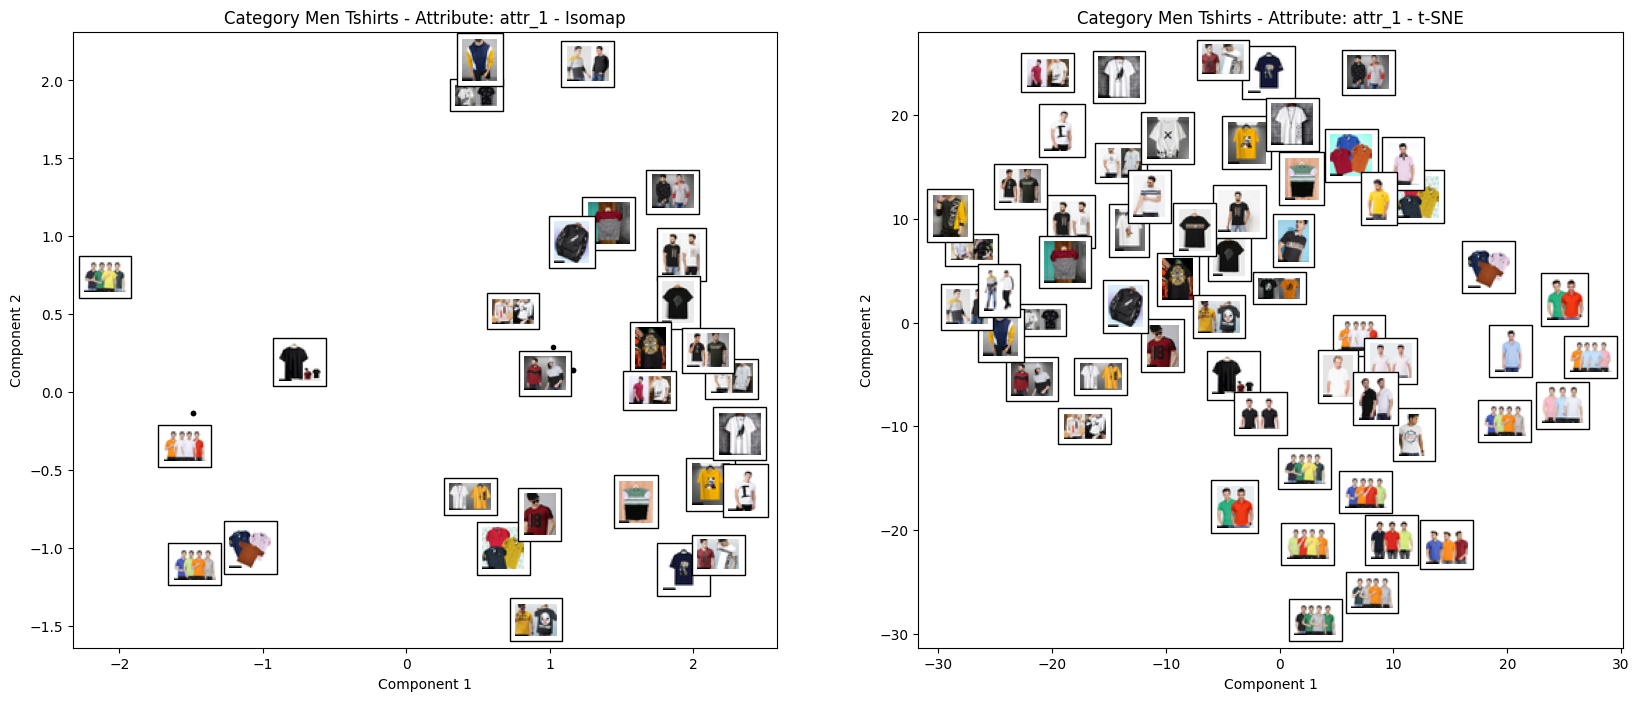

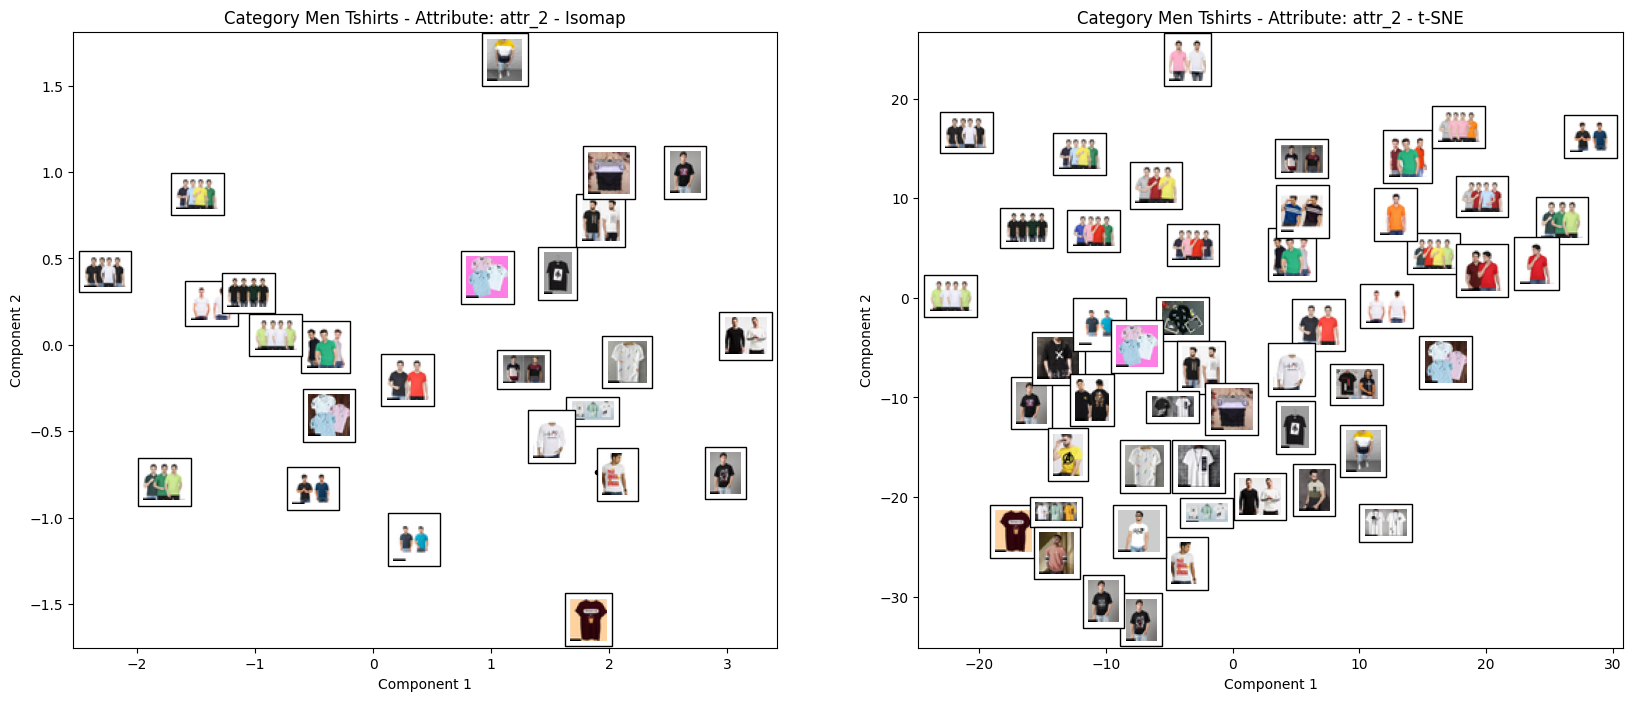

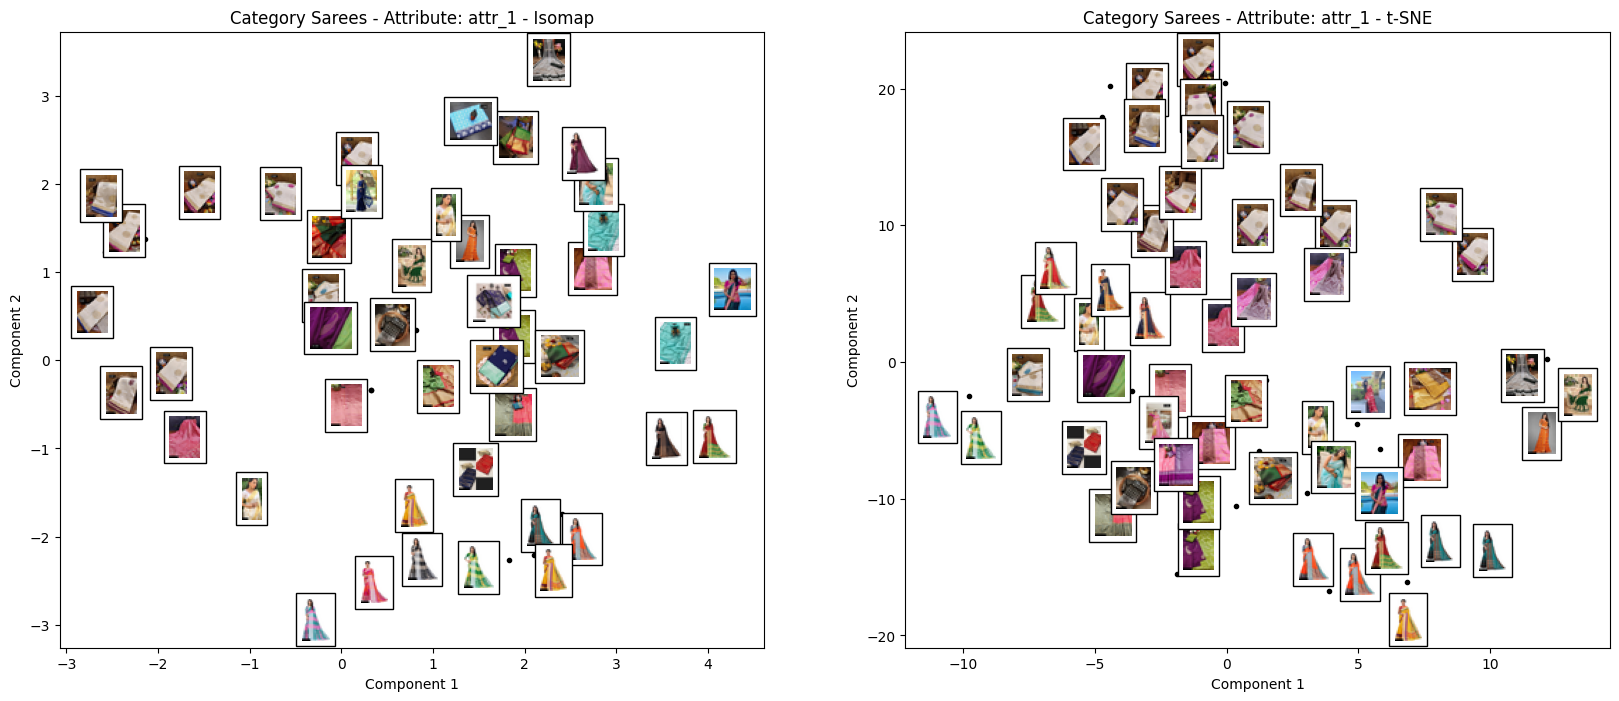

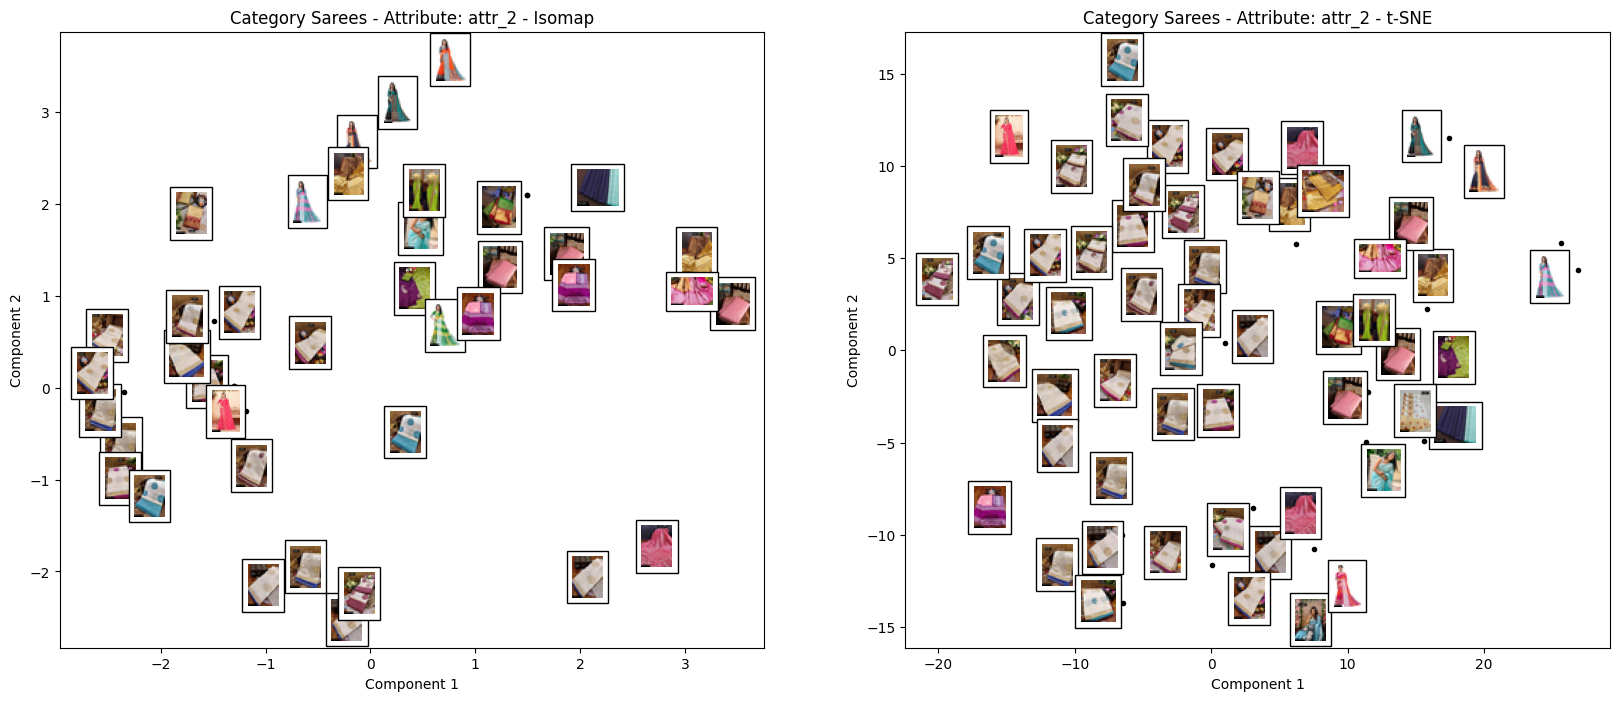

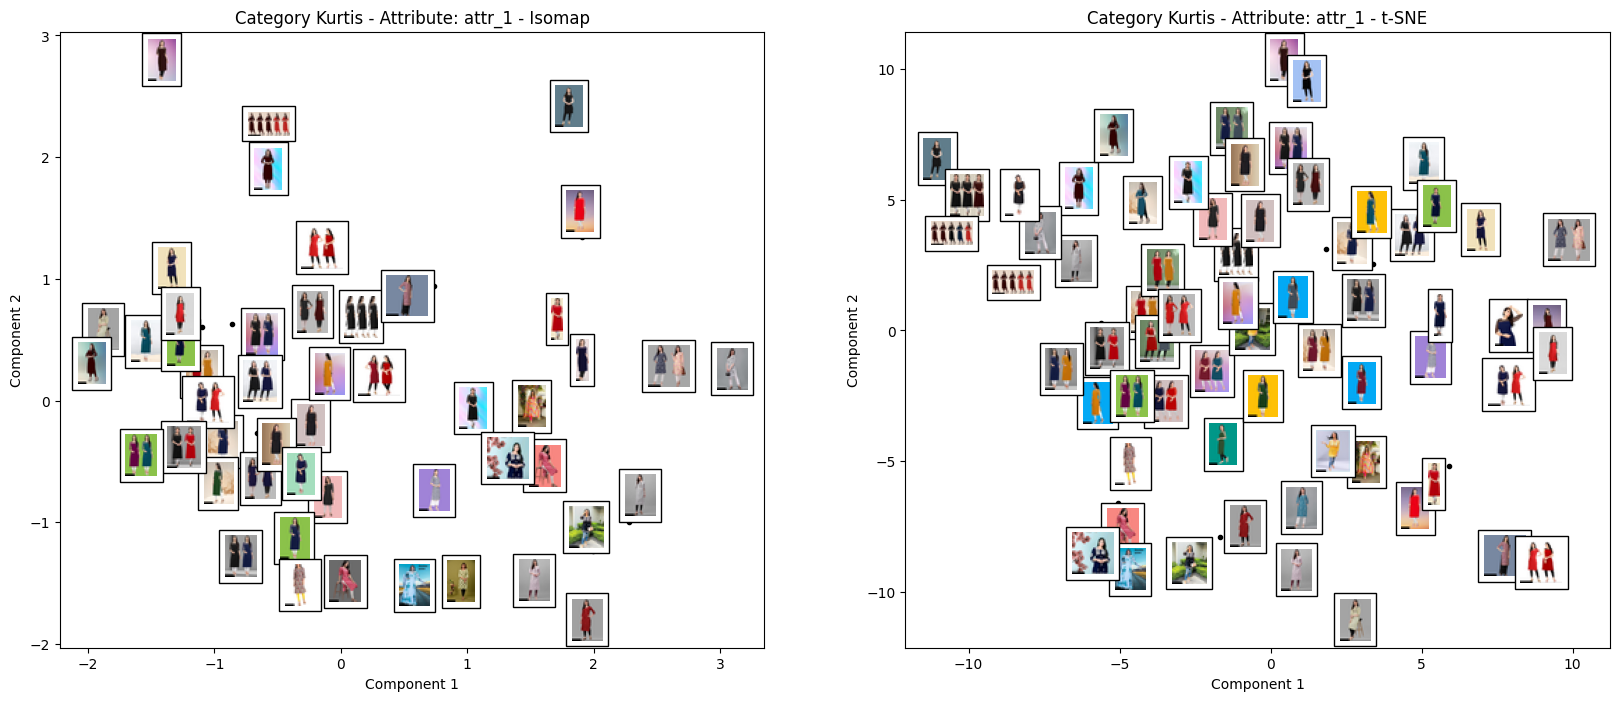

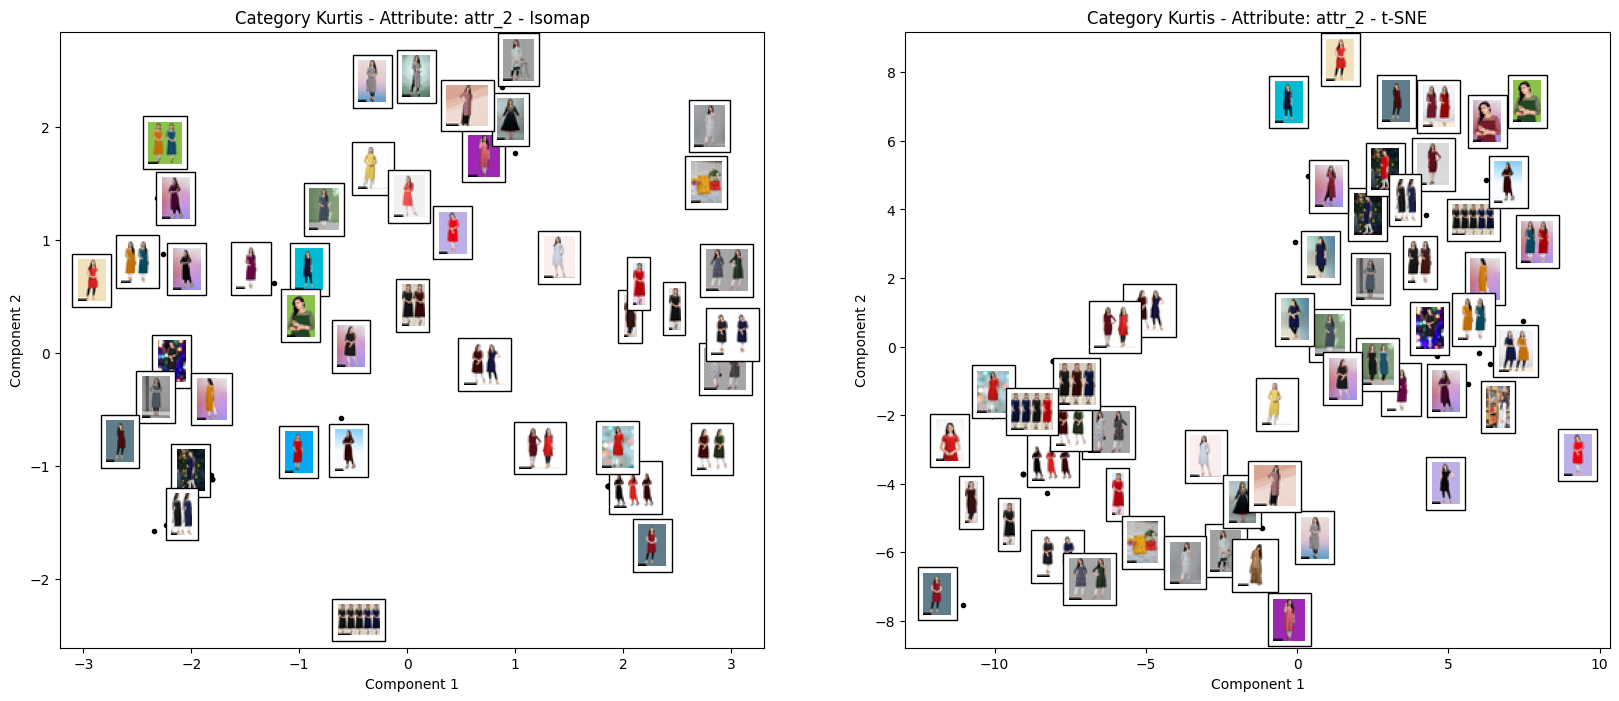

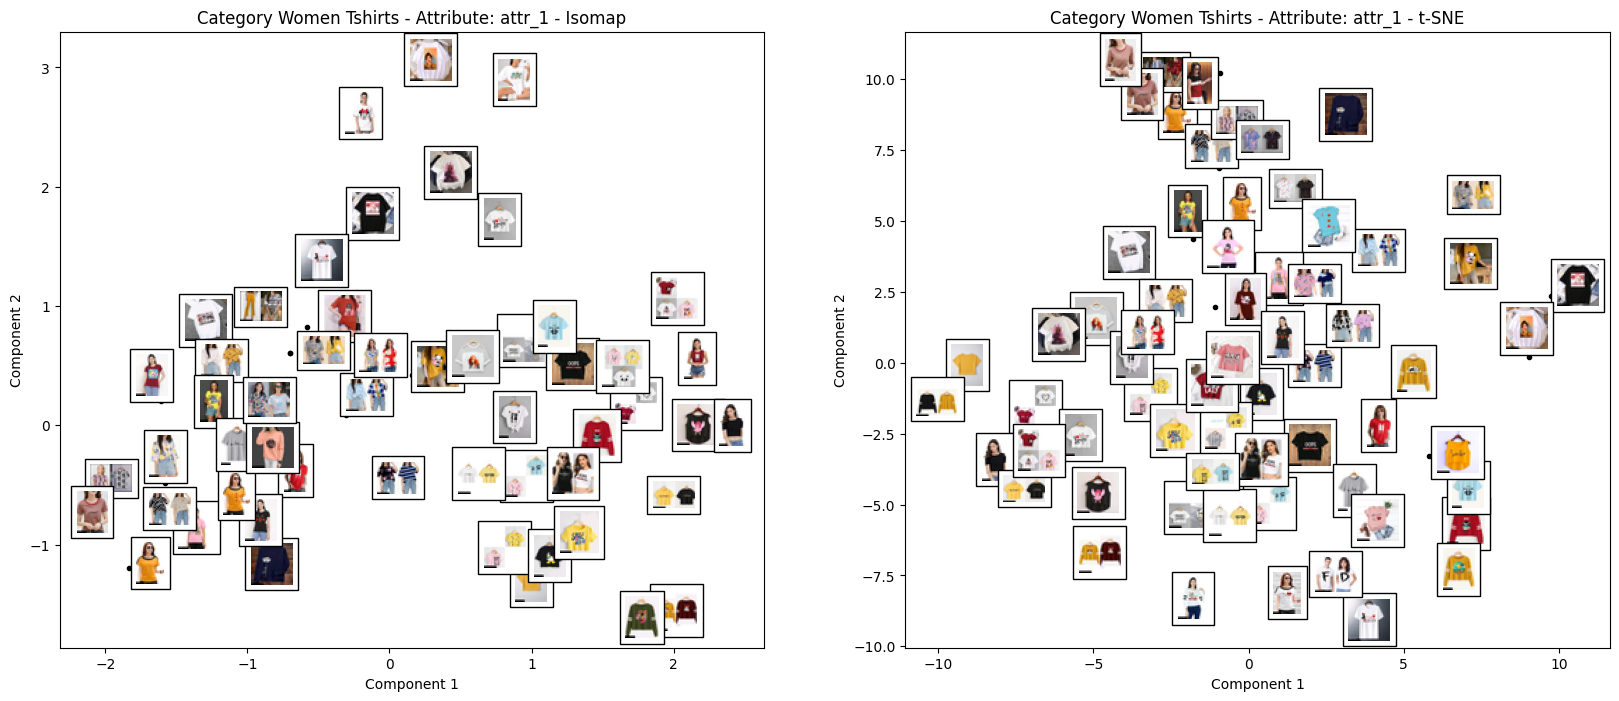

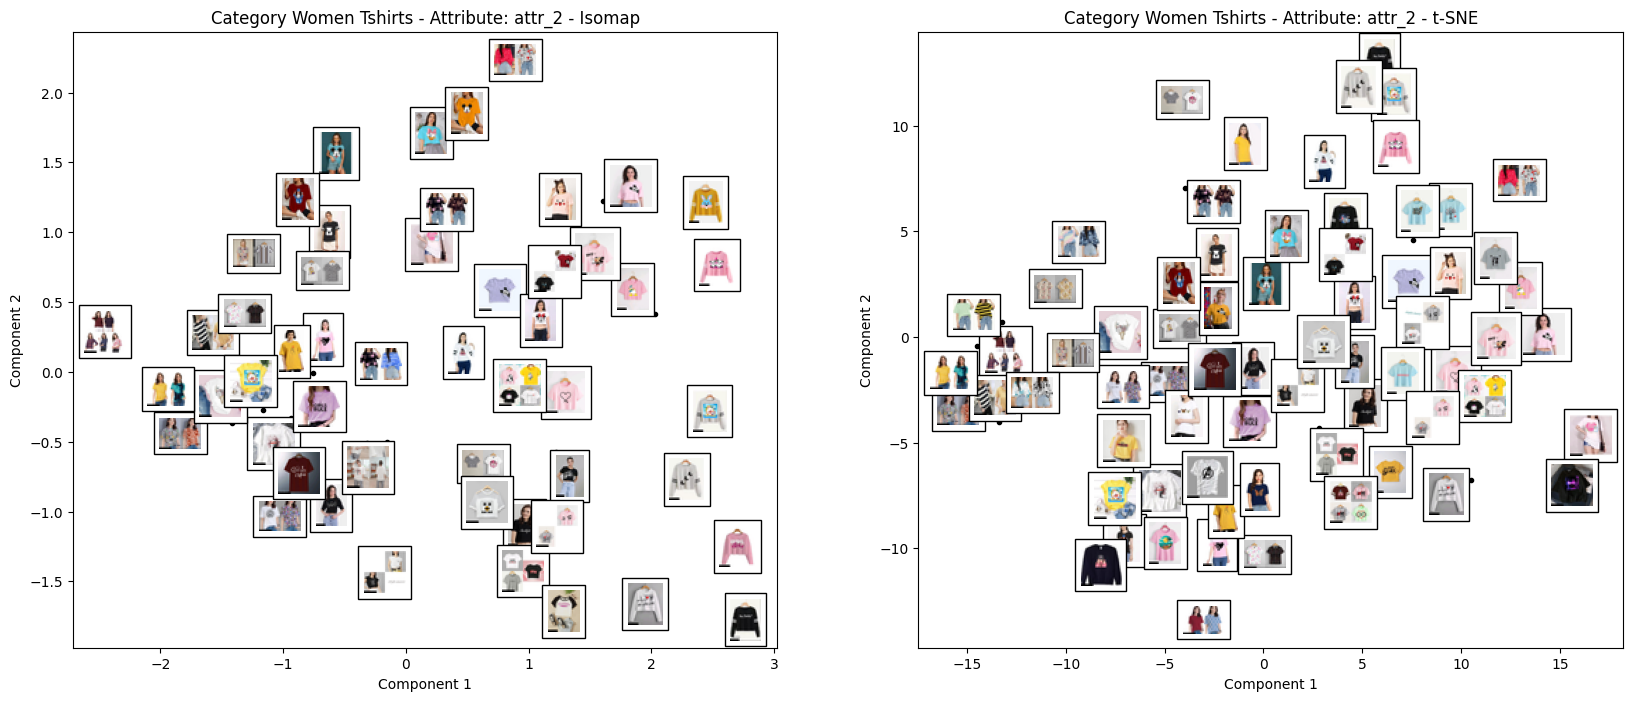

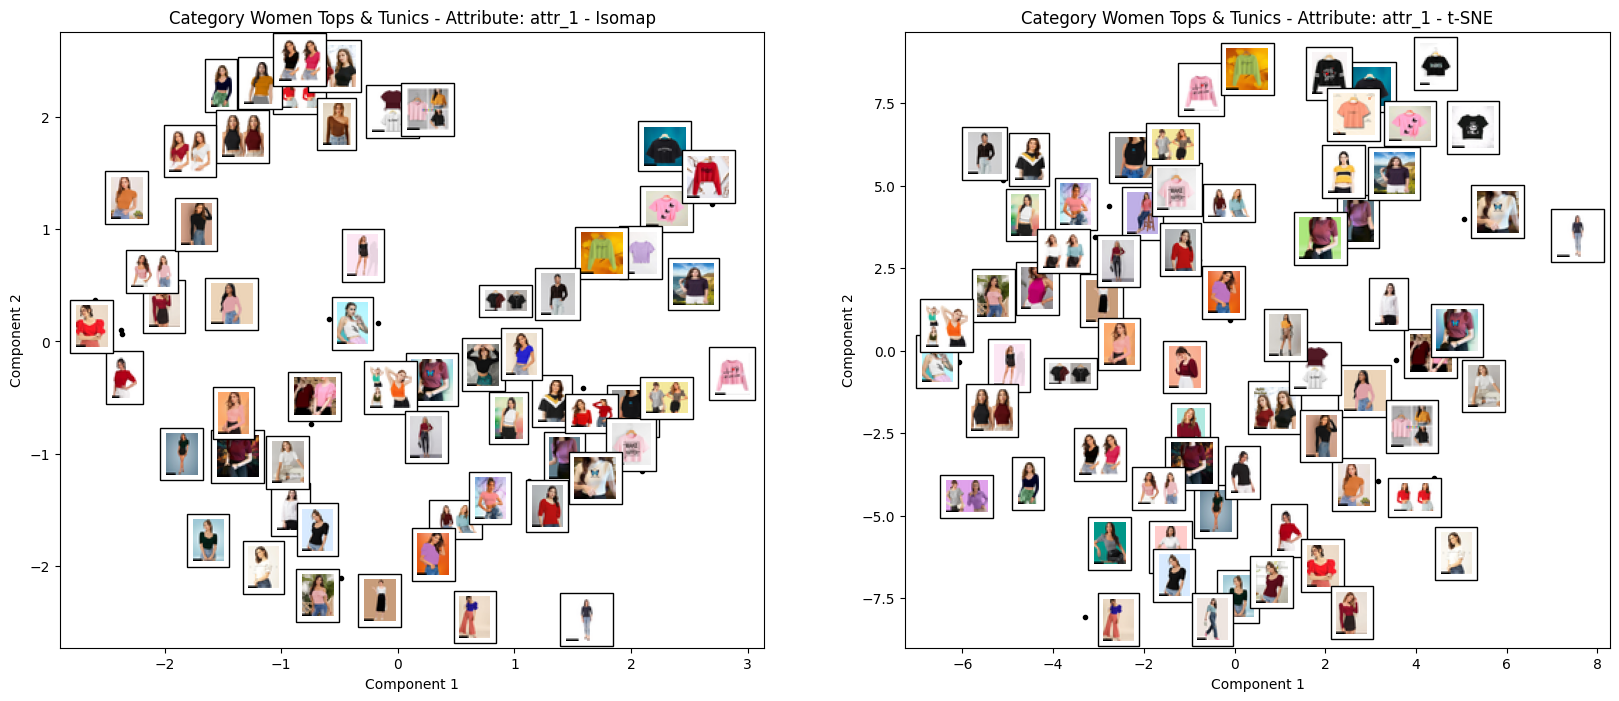

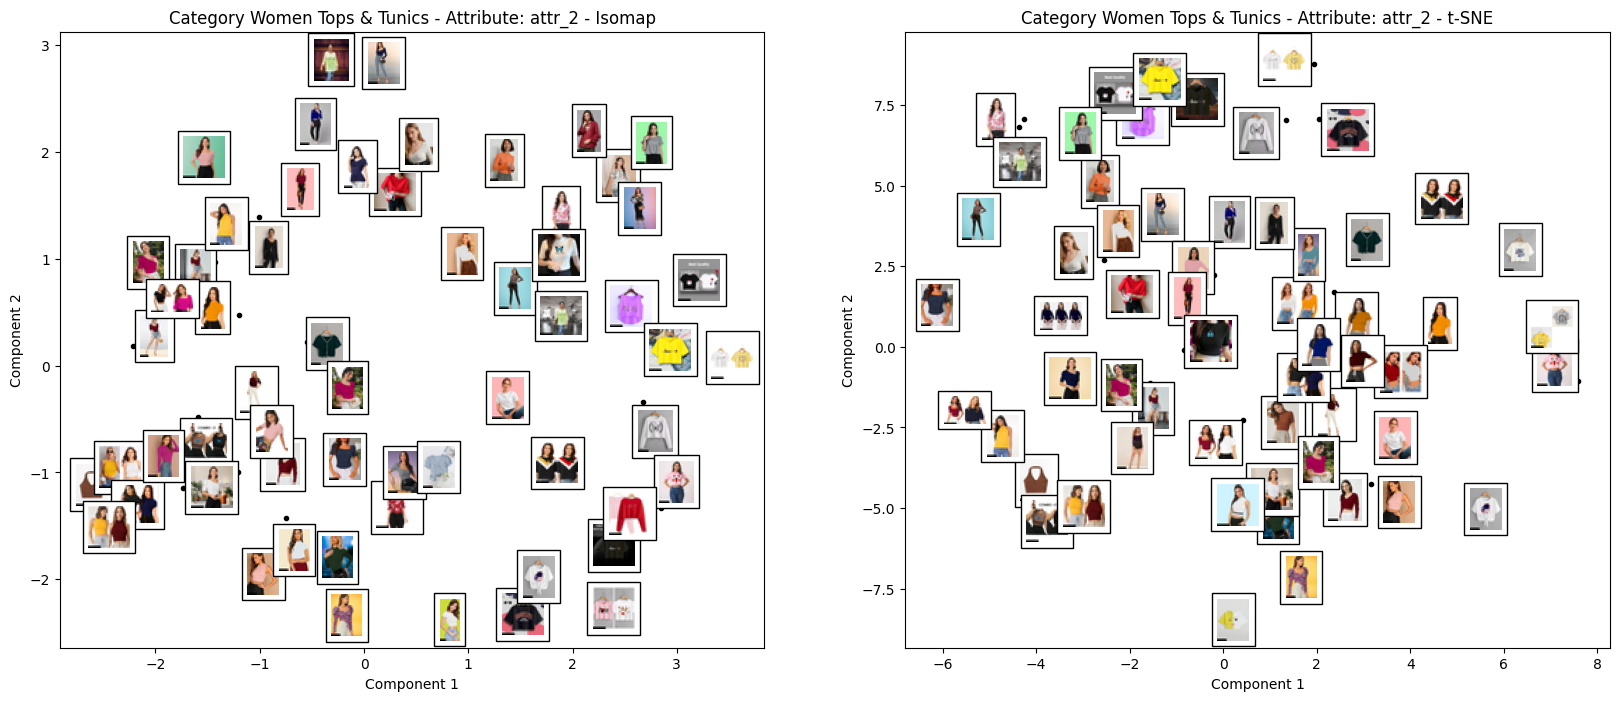

In [158]:
# Iterate over each unique bucket and call the function
for bucket, data in encoded_data.items():
    visualize_manifold_learning(data, f"Category {bucket[0]} - Attribute: {bucket[1]}")